# Solución de raspado web

## Paso 1: Instalar dependencias

In [3]:
pip install pandas requests lxml

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Paso 2: Descargar HTML

In [4]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import io

# Obtener el HTML
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
response = requests.get(url)
# Verificamos la respuesta
print("Estado:", response.status_code)

Estado: 200


## Paso 3: Transformar el HTML

In [5]:
# Extraer las tablas con pandas
html = io.StringIO(response.text)
tables = pd.read_html(html)
print(f"Se encontraron {len(tables)} tablas.")

Se encontraron 27 tablas.


In [6]:
# Inspeccionamos las primeras filas de la tabla correcta
df = tables[0] # extrae la primera tabla de las 27 encontradas
df.head()  # Muestra las primeras 5 filas

,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,4.804,29 November 2019,[2]
1,2,"""Shape of You""",Ed Sheeran,4.324,6 January 2017,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.876,8 November 2018,[4]
3,4,"""Starboy""",The Weeknd and Daft Punk,3.853,21 September 2016,[5]
4,5,"""As It Was""",Harry Styles,3.846,1 April 2022,[6]


## Paso 4: Procesar el marco de datos

In [7]:
# Limpieza de datos

# Renombramos columnas si es necesario
df.columns = ["Rank", "Song", "Artist", "Streams (billions)", "Date released", "Reference"]

# Eliminamos notas entre corchetes
df["Song"] = df["Song"].str.replace(r"\[.*?\]", "", regex=True)
df["Artist"] = df["Artist"].str.replace(r"\[.*?\]", "", regex=True)

df = df[df["Streams (billions)"].astype(str).str.contains(r"^\d+(?:\.\d+)?$", na=False)].copy()

# Convertimos Streams a números flotantes
df["Streams (billions)"] = df["Streams (billions)"].astype(float)

# Convertimos fechas a datetime
df["Date released"] = pd.to_datetime(df["Date released"], errors="coerce")

df

,Rank,Song,Artist,Streams (billions),Date released,Reference
0,1,"""Blinding Lights""",The Weeknd,4.804,2019-11-29,[2]
1,2,"""Shape of You""",Ed Sheeran,4.324,2017-01-06,[3]
2,3,"""Someone You Loved""",Lewis Capaldi,3.876,2018-11-08,[4]
3,4,"""Starboy""",The Weeknd and Daft Punk,3.853,2016-09-21,[5]
4,5,"""As It Was""",Harry Styles,3.846,2022-04-01,[6]
...,...,...,...,...,...,...
95,96,"""Stay with Me""",Sam Smith,2.279,2014-04-14,[97]
96,97,"""All the Stars""",Kendrick Lamar and SZA,2.272,2018-01-04,[98]
97,98,"""Someone Like You""",Adele,2.269,2011-01-24,[99]
98,99,"""Havana""",Camila Cabello and Young Thug,2.267,2017-08-03,[100]


## Paso 5: almacenar los datos en sqlite

In [8]:
# Create the database
conn = sqlite3.connect("spotify_top_songs.db")

In [9]:
# Create table in SQLite
df.to_sql("most_streamed", conn, if_exists="replace", index=False)
cursor = conn.cursor()

In [10]:
# Insert data into the database
cursor.execute("SELECT COUNT(*) FROM most_streamed")
print("Rows inserted:", cursor.fetchone()[0])

conn.commit()
conn.close()

Rows inserted: 100


## Paso 6: Visualiza los datos

### Análisis visual de la popularidad en Spotify

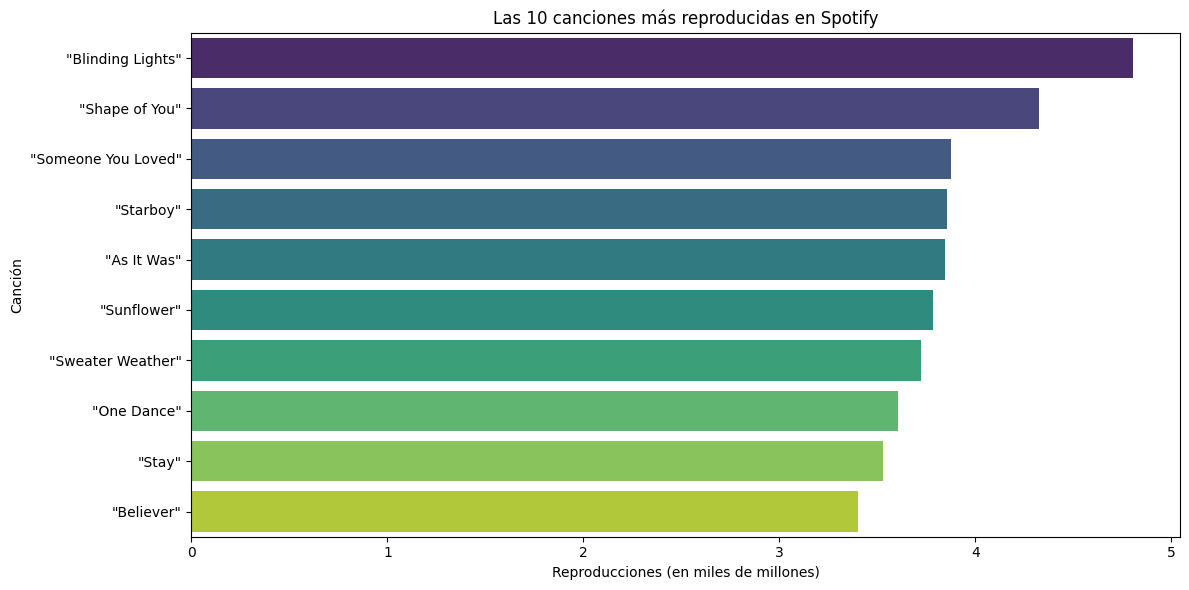

In [11]:
# Graficar los datos

# Gráfico 1: Las 10 canciones más reproducidas
top10 = df.nlargest(10, "Streams (billions)")
plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x="Streams (billions)", y="Song", hue="Song", palette="viridis", legend=False)
plt.title("Las 10 canciones más reproducidas en Spotify")
plt.xlabel("Reproducciones (en miles de millones)")
plt.ylabel("Canción")
plt.tight_layout()
plt.show()

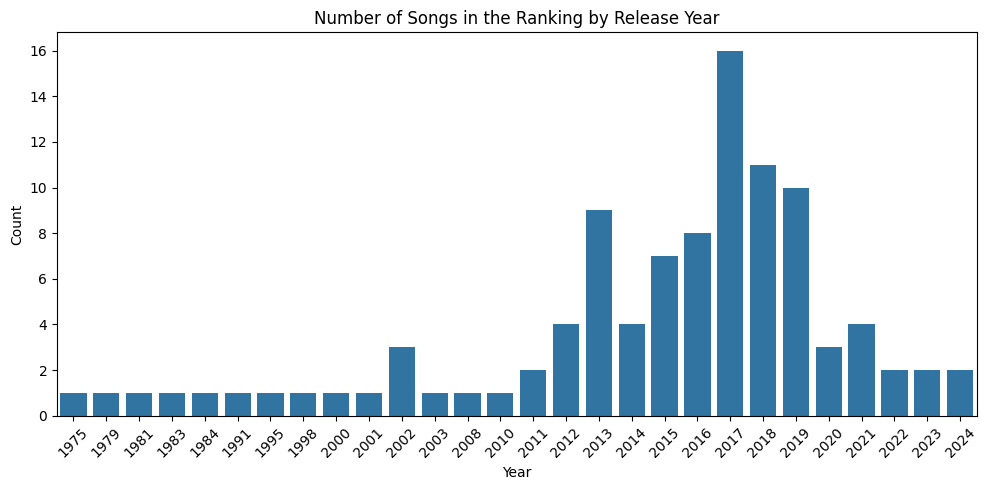

In [12]:
# Chart 2: Number of songs per year
df["Year"] = df["Date released"].dt.year
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="Year", order=sorted(df["Year"].dropna().unique()))
plt.title("Number of Songs in the Ranking by Release Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

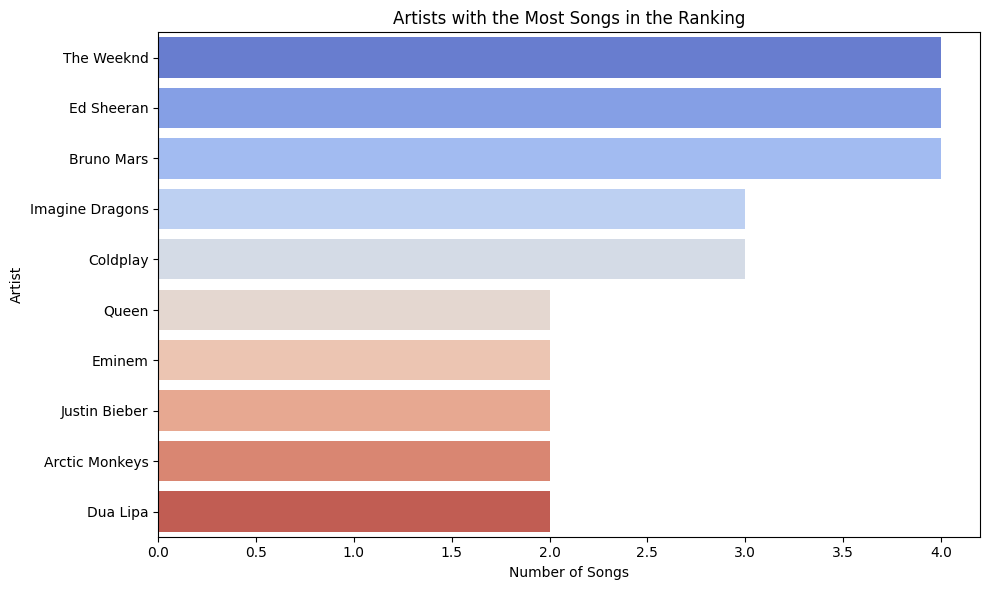

In [13]:
# Chart 3: Artists with the most songs in the ranking

# Note: Some artists have multiple songs
artists = df["Artist"].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=artists.values, y=artists.index, hue=artists.index, palette="coolwarm", legend=False)
plt.title("Artists with the Most Songs in the Ranking")
plt.xlabel("Number of Songs")
plt.ylabel("Artist")
plt.tight_layout()
plt.show()